In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import IBMQ, QuantumCircuit, Aer, transpile, assemble
from qiskit.visualization import plot_histogram
from math import gcd
from numpy.random import randint
import pandas as pd
from qiskit.providers.ibmq import least_busy
from fractions import Fraction

In [2]:
def qft_inv(n):
    qc = QuantumCircuit(n)
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT_INV"
    return qc

In [3]:
n_count = 3
n = 5
qc = QuantumCircuit(n_count+2, n_count)
for q in range(n_count):
    qc.h(q)

qc.cx(2,4)

qc.cx(1,4)
qc.cx(4,3)
qc.ccx(1,3,4)
qc.cx(4,3)

qc.x(4)
qc.cswap(3,0,4)
qc.x(4)
qc.cx(4,3)
qc.ccx(0,3,4)
qc.cx(4,3)
qc.barrier()
qc.append(qft_inv(n_count), range(n_count))
qc.measure(range(n_count), range(n_count))
qc.draw()

┌───┐                                                      ░ ┌──────────┐»
q_0: ┤ H ├───────────────────────────────X─────────────■────────░─┤0         ├»
     ├───┤                               │             │        ░ │          │»
q_1: ┤ H ├───────■─────────■─────────────┼─────────────┼────────░─┤1 QFT_INV ├»
     ├───┤       │         │             │             │        ░ │          │»
q_2: ┤ H ├──■────┼─────────┼─────────────┼─────────────┼────────░─┤2         ├»
     └───┘  │    │  ┌───┐  │  ┌───┐      │      ┌───┐  │  ┌───┐ ░ └──────────┘»
q_3: ───────┼────┼──┤ X ├──■──┤ X ├──────■──────┤ X ├──■──┤ X ├─░─────────────»
          ┌─┴─┐┌─┴─┐└─┬─┘┌─┴─┐└─┬─┘┌───┐ │ ┌───┐└─┬─┘┌─┴─┐└─┬─┘ ░             »
q_4: ─────┤ X ├┤ X ├──■──┤ X ├──■──┤ X ├─X─┤ X ├──■──┤ X ├──■───░─────────────»
          └───┘└───┘     └───┘     └───┘   └───┘     └───┘      ░             »
c: 3/═════════════════════════════════════════════════════════════════════════»
                                                                              »
«     ┌─┐      
«q_0: ┤M├──────
«     └╥┘┌─┐   
«q_1: ─╫─┤M├───
«      ║ └╥┘┌─┐
«q_2: ─╫──╫─┤M├
«      ║  ║ └╥┘
«q_3: ─╫──╫──╫─
«      ║  ║  ║ 
«q_4: ─╫──╫──╫─
«      ║  ║  ║ 
«c: 3/═╩══╩══╩═
«      0  1  2

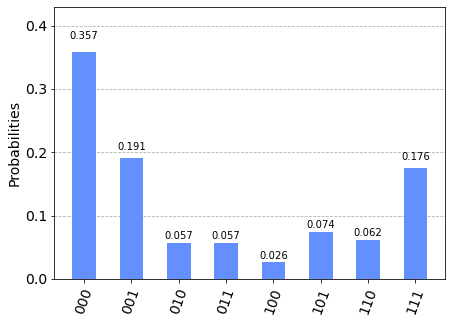

In [4]:
aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc, aer_sim)
qobj = assemble(t_qc)
results = aer_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)

In [5]:
# Load our saved IBMQ accounts and get the least busy backend device with less than or equal to 5 qubits
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= n and 
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

# Execute and monitor the job
from qiskit.tools.monitor import job_monitor
shots = 1024
transpiled_simon_circuit = transpile(qc, backend, optimization_level=3)
qobj = assemble(transpiled_simon_circuit, shots=shots)
job = backend.run(qobj)
job_monitor(job, interval=2)

least busy backend:  ibmq_manila


<ipython-input-5-5f8f17d7194d>:13: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(qobj)


Job Status: job has successfully run


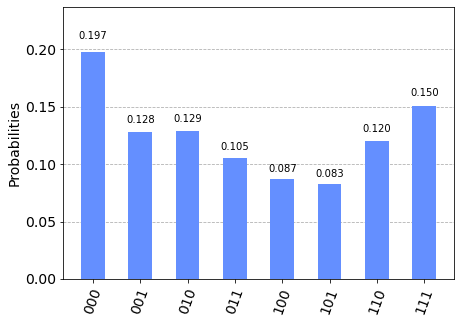

In [6]:
# Get results and plot counts
device_counts = job.result().get_counts()
plot_histogram(device_counts)

In [7]:
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**n_count)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)", 
                 f"{decimal}/{2**n_count} = {phase:.2f}"])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

       Register Output       Phase
0  101(bin) =   5(dec)  5/8 = 0.62
1  111(bin) =   7(dec)  7/8 = 0.88
2  000(bin) =   0(dec)  0/8 = 0.00
3  011(bin) =   3(dec)  3/8 = 0.38
4  001(bin) =   1(dec)  1/8 = 0.12
5  110(bin) =   6(dec)  6/8 = 0.75
6  010(bin) =   2(dec)  2/8 = 0.25
7  100(bin) =   4(dec)  4/8 = 0.50


In [8]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase, f"{frac.numerator}/{frac.denominator}", frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

   Phase Fraction  Guess for r
0  0.625      5/8            8
1  0.875      7/8            8
2  0.000      0/1            1
3  0.375      3/8            8
4  0.125      1/8            8
5  0.750      3/4            4
6  0.250      1/4            4
7  0.500      1/2            2


In [9]:
rows, measured_phases = [], []
for output in device_counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**n_count)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)", 
                 f"{decimal}/{2**n_count} = {phase:.2f}"])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

       Register Output       Phase
0  000(bin) =   0(dec)  0/8 = 0.00
1  001(bin) =   1(dec)  1/8 = 0.12
2  010(bin) =   2(dec)  2/8 = 0.25
3  011(bin) =   3(dec)  3/8 = 0.38
4  100(bin) =   4(dec)  4/8 = 0.50
5  101(bin) =   5(dec)  5/8 = 0.62
6  110(bin) =   6(dec)  6/8 = 0.75
7  111(bin) =   7(dec)  7/8 = 0.88


In [10]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase, f"{frac.numerator}/{frac.denominator}", frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

   Phase Fraction  Guess for r
0  0.000      0/1            1
1  0.125      1/8            8
2  0.250      1/4            4
3  0.375      3/8            8
4  0.500      1/2            2
5  0.625      5/8            8
6  0.750      3/4            4
7  0.875      7/8            8
